# General Travelling Sales Person

In addition to being a notorious NP-hard problem that has drawn the attention of computer scientists and mathematicians for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. 

Colloquially speaking, the traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to its hometown, i.e. the city where he started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time.

The problem derives its importance from its “hardness” and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.

The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of Max-Cut, best abstracted in terms of network graphs. 

The TSP on the nodes of a graph asks for the shortest Hamiltonian cycle that can be taken through each of the nodes. A Hamilton cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.



In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pylab

# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.quantum_burden import compute_quantum_burden
from qaoa_vrp.classical.greedy_tsp import greedy_tsp
from qaoa_vrp.plot.draw_euclidean_graphs import draw_euclidean_graph

# QISKIT stuff
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver,VQE
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, NELDER_MEAD, SPSA
from qiskit.circuit import Parameter
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
)
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import max_cut, tsp

# import logging
# logging.basicConfig(level=logging.INFO)
# logging.getLogger('qiskit.algorithms.minimum_eigen_solvers.vqe').setLevel(logging.INFO)

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/finance/__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimizati

In [2]:
filename="instanceType_euclidean_tsp_numNodes_4_numVehicles_1_87a170c748e240d0b71d5fb7fe7de707.json"
instance_path = "../data/{}".format(filename)
with open(instance_path) as f:
        data = json.load(f)

In [3]:
# Build Graph
G, depot_info = qaoa_vrp.build_graph.build_json_graph(data["graph"])
num_vehicles = int(data["numVehicles"])
threshold = float(data["threshold"])
n_max = int(data["n_max"])
instance_type = data["instance_type"]
p_max = data["p_max"]


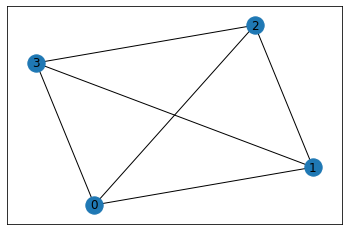

In [4]:
nx.draw_networkx(G)

In [5]:
# Create QAOA parameter dictionary
qaoa_dict = qaoa_vrp.utils.create_qaoa_params(threshold, n_max, p_max)

In [6]:
# Build Graph Feature Vector
feature_vector = qaoa_vrp.features.graph_features.get_graph_features(G)
# Build TSP Feature Vector
tsp_feature_vector = qaoa_vrp.features.tsp_features.get_tsp_features(G)
# Add num vehicles
feature_vector["num_vehicles"] = num_vehicles

In [7]:
depot_edges = list(G.edges(depot_info["id"], data=True))
depot_node = depot_info["id"]

In [8]:
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))

In [9]:
G, cluster_mapping = qaoa_vrp.clustering.create_clusters(
    G, num_vehicles, "spectral-clustering", edge_mat
)

subgraphs = qaoa_vrp.clustering.build_sub_graphs(G, depot_node, depot_edges)

qubos = qaoa_vrp.build_circuit.build_qubos(subgraphs, depot_info)

qubos_solution_data = []

cluster_mapping = [i + 1 for i in cluster_mapping]
cluster_mapping.insert(0, 0)

In [49]:
qubo = qubos[0]
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 119.870490707263 X11 - 120 X12 - 119.870490707263 X13
      - 119.544965007869 X21 - 120 X22 - 119.544965007869 X23
      - 119.830216603413 X31 - 120 X32 - 119.830216603413 X33 + [ 120 X11^2
      + 120 X11*X12 + 120 X11*X13 + 120 X11*X21 + 0.656366125546 X11*X22
      + 120 X11*X31 + 0.573070695708 X11*X32 + 120 X12^2 + 120 X12*X13
      + 0.656366125546 X12*X21 + 120 X12*X22 + 0.656366125546 X12*X23
      + 0.573070695708 X12*X31 + 120 X12*X32 + 0.573070695708 X12*X33
      + 120 X13^2 + 0.656366125546 X13*X22 + 120 X13*X23
      + 0.573070695708 X13*X32 + 120 X13*X33 + 120 X21^2 + 120 X21*X22
      + 120 X21*X23 + 120 X21*X31 + 1.227988238243 X21*X32 + 120 X22^2
      + 120 X22*X23 + 1.227988238243 X22*X31 + 120 X22*X32
      + 1.227988238243 X22*X33 + 120 X23^2 + 1.227988238243 X23*X32
      + 120 X23*X33 + 120 X31^2 + 120 X31*X32 + 120 X31*X33 + 120 X32^2
      + 120 X32*X33 + 1

In [48]:
single_qubo_solution_data = {}
single_qubo_solution_data["qubo_id"] = 0
single_qubo_solution_data["cluster"] = [
    index
    for index, node in enumerate(cluster_mapping)
    if node == 1 or node == 0
]
num_nodes=len(single_qubo_solution_data['cluster'])

# Solving the QAOA

Lets write some basic functions to find the solution from the result and also one to compute the cost based on our original graph

In [15]:
op, offset = qubo.to_ising()
num_qubits = qubo.get_num_vars()

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


In [16]:
print('Offset:', offset)
print('Ising Hamiltonian:')
print(op.print_details())

Offset: 181.9830402112039
Ising Hamiltonian:
IIIIIIIIZ	(-30.218434249025503+0j)
IIIIIIZII	(-30.2184342490255+0j)
IIIIIZIII	(-30.463061791538866+0j)
IIIZIIIII	(-30.463061791538866+0j)
IIZIIIIII	(-30.310024065037577+0j)
ZIIIIIIII	(-30.31002406503758+0j)
IIIIIIIZI	(-30.307359205313634+0j)
IIIIZIIII	(-30.471088590947225+0j)
IZIIIIIII	(-30.45026473348771+0j)
IIIIIIIZZ	(15+0j)
IIIIIIZIZ	(15+0j)
IIIIIIZZI	(15+0j)
IIIIIZIIZ	(15+0j)
IIIIIZIZI	(0.082045765693287+0j)
IIIIZIIIZ	(0.082045765693287+0j)
IIIIZIIZI	(15+0j)
IIIIZIZII	(0.082045765693287+0j)
IIIIZZIII	(15+0j)
IIIZIIIZI	(0.082045765693287+0j)
IIIZIIZII	(15+0j)
IIIZIZIII	(15+0j)
IIIZZIIII	(15+0j)
IIZIIIIIZ	(15+0j)
IIZIIIIZI	(0.07163383696353035+0j)
IIZIIZIII	(15+0j)
IIZIZIIII	(0.15349852978032563+0j)
IZIIIIIIZ	(0.07163383696353035+0j)
IZIIIIIZI	(15+0j)
IZIIIIZII	(0.07163383696353035+0j)
IZIIIZIII	(0.15349852978032563+0j)
IZIIZIIII	(15+0j)
IZIZIIIII	(0.15349852978032563+0j)
IZZIIIIII	(15+0j)
ZIIIIIIZI	(0.07163383696353035+0j)
ZIIIIIZII	(15+0

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/list_ops/summed_op.py:193: DeprecationWarning: print_details() is deprecated and will be removed in a future release. Instead you can use .to_legacy_op() and call print_details() on it's output
  warnings.warn("print_details() is deprecated and will be removed in "


In [17]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 59.870491 x_0 - 60.000000 x_1 - 59.870491 x_2 - 59.544965 x_3 - 60 x_4
 - 59.544965 x_5 - 59.830217 x_6 - 60 x_7 - 59.830217 x_8 [ 60 x_0*x_1
 + 60 x_0*x_2 + 60 x_0*x_3 + 0.328183 x_0*x_4 + 60 x_0*x_6 + 0.286535 x_0*x_7
 + 60 x_1*x_2 + 0.328183 x_1*x_3 + 60 x_1*x_4 + 0.328183 x_1*x_5
 + 0.286535 x_1*x_6 + 60 x_1*x_7 + 0.286535 x_1*x_8 + 0.328183 x_2*x_4
 + 60 x_2*x_5 + 0.286535 x_2*x_7 + 60 x_2*x_8 + 60 x_3*x_4 + 60 x_3*x_5
 + 60 x_3*x_6 + 0.613994 x_3*x_7 + 60 x_4*x_5 + 0.613994 x_4*x_6 + 60 x_4*x_7
 + 0.613994 x_4*x_8 + 0.613994 x_5*x_7 + 60 x_5*x_8 + 60 x_6*x_7 + 60 x_6*x_8
 + 60 x_7*x_8 ] + 180.000000;
 
subject to {

}


In [18]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact.solve(qp)
print(exact_result)

optimal function value: 1.2395367993452528
optimal value: [0. 1. 0. 0. 0. 1. 1. 0. 0.]
status: SUCCESS


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.minimum_eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.minimum_eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.minimum_eigen_solvers',
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/eigen_solvers/eigen_solver.py:36: DeprecationWarning: The package qiskit.aqua.algorithms.eigen_solvers is deprecated. It was moved/refactored to qiskit.algorithms.eigen_solvers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.eigen_solvers',


In [19]:
ee = NumPyMinimumEigensolver(op)
result = ee.run()

In [20]:
print('energy:', result.eigenvalue.real)
print('tsp objective:', result.eigenvalue.real + offset)
x = sample_most_likely(result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, cost_mat))

energy: -180.74350341185865
tsp objective: 1.2395367993452453
feasible: True
solution: [2, 0, 1]
solution objective: 0.9127273476410219


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:215: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  unique, counts = np.unique(aqua_globals.random.choice(list(deterministic_counts.keys()),


## Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_{entangler}$.

In [21]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, NELDER_MEAD, SPSA

We will show the callback usage below over a set of optimizers for comparison. The minimum energy of the Qubo Hamiltonian can be found quite easily so we are able to set maxiters to a small value

In [22]:
optimizers = [
    SLSQP(maxiter=200, disp=True),
    COBYLA(maxiter=200, disp=True), 
    NELDER_MEAD(maxiter=200),
    SPSA(maxiter=200),
    L_BFGS_B(maxiter=200)
]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
backend = Aer.get_backend('aer_simulator_matrix_product_state')


$$p = 1$$

In [23]:
p = 1
for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__))
    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    # Set seed
    aqua_globals.random_seed = np.random.default_rng(123)
    seed = 10598
    # Set backend 
    quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
    qaoa = QAOA(
        operator=op,
        optimizer=optimizer,
        callback=store_intermediate_result,
        p=p,
        initial_point = [np.random.uniform(0,1) for i in range(2*p)],
        quantum_instance=quantum_instance
    )
    result = qaoa.compute_minimum_eigenvalue(operator=op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
print('\rOptimization complete      ');    

Optimizer: SLSQP        


/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:70: DeprecationWarning: The class qiskit.aqua.algorithms.VQAlgorithm is deprecated. It was moved/refactored to qiskit.algorithms.VariationalAlgorithm (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.algorithms.VQAlgorithm',
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/components/variational_forms/variati

Optimization terminated successfully    (Exit mode 0)
            Current function value: 65.25102642141343
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Optimizer: COBYLA        

   Normal return from subroutine COBYLA

   NFVALS =   29   F =-1.041118E+02    MAXCV = 0.000000E+00
   X = 2.201236E-01  -3.677437E-01
Optimizer: NELDER_MEAD        
Optimizer: SPSA        
Optimizer: L_BFGS_B        
Optimization complete      


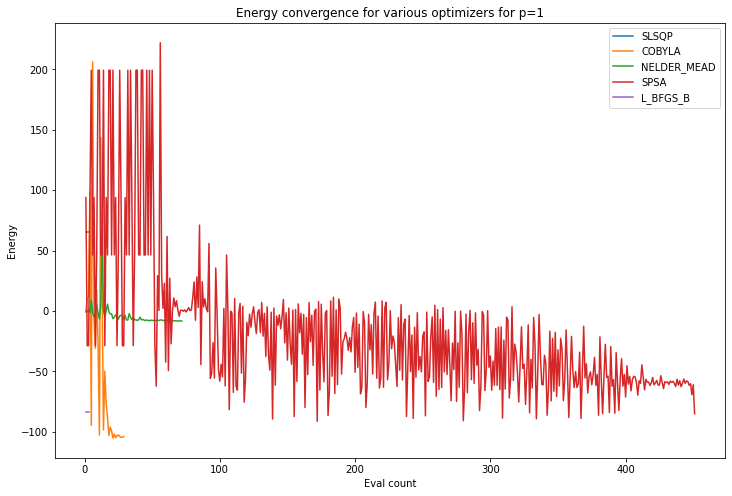

In [24]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title(f'Energy convergence for various optimizers for p={p}')
pylab.legend(loc='upper right');

In [25]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -180.74350


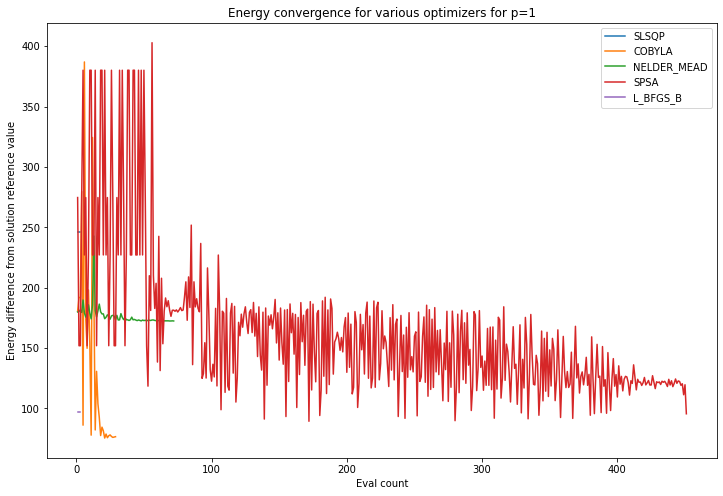

In [26]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
        pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title(f'Energy convergence for various optimizers for p={p}')
pylab.legend(loc='upper right');

In [27]:
x = sample_most_likely(result.eigenstate)
try:
    z = tsp.get_tsp_solution(x)
    print('feasible:', tsp.tsp_feasible(x))    
    print('solution objective:', tsp.tsp_value(z, cost_mat))
    print('solution:', z)
except:
    print('feasible:', tsp.tsp_feasible(x))

feasible: True
solution objective: 0.9127273476410219
solution: [2, 0, 1]


$$
    p = 2
$$

In [36]:
p = 2
for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__))
    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    # Set seed
    aqua_globals.random_seed = np.random.default_rng(123)
    seed = 10598
    # Set backend 
    quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
    qaoa = QAOA(
        operator=op,
        optimizer=optimizer,
        callback=store_intermediate_result,
        p=p,
        initial_point = [np.random.uniform(0,1) for i in range(2*p)],
        quantum_instance=quantum_instance
    )
    result = qaoa.compute_minimum_eigenvalue(operator=op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
print('\rOptimization complete      ');    

Optimizer: SLSQP        
Optimization terminated successfully    (Exit mode 0)
            Current function value: 41.493261516827324
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Optimizer: COBYLA        

   Normal return from subroutine COBYLA

   NFVALS =   51   F =-4.957632E+01    MAXCV = 0.000000E+00
   X = 2.593897E-02   1.636173E-01   2.328961E-01   1.357600E+00
Optimizer: NELDER_MEAD        
Optimizer: SPSA        
Optimizer: L_BFGS_B        
Optimization complete      


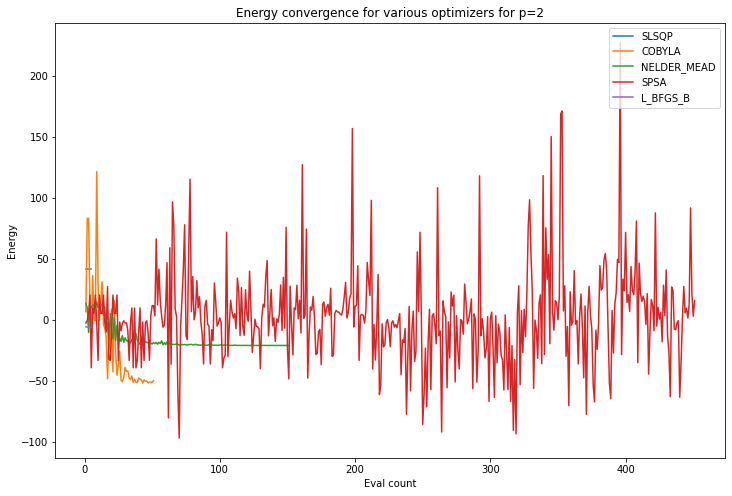

In [37]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title(f'Energy convergence for various optimizers for p={p}')
pylab.legend(loc='upper right');

In [38]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -180.74350


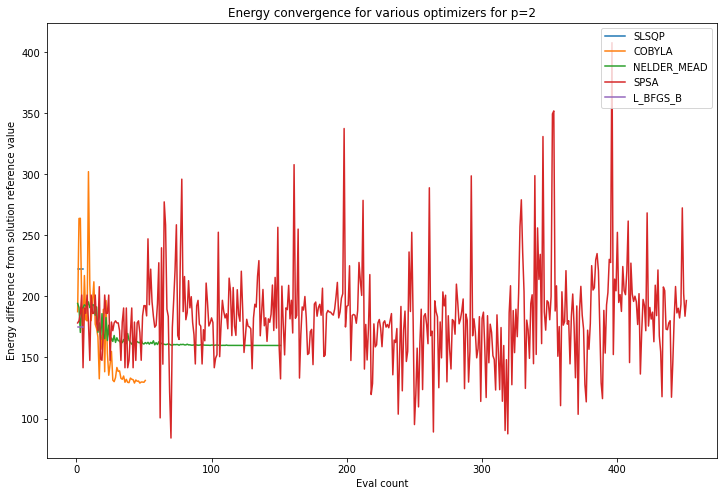

In [39]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title(f'Energy convergence for various optimizers for p={p}')
pylab.legend(loc='upper right');

In [32]:
p = 3
for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__))
    counts = []
    values = []
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    # Set seed
    aqua_globals.random_seed = np.random.default_rng(123)
    seed = 10598
    # Set backend 
    quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
    qaoa = QAOA(
        operator=op,
        optimizer=optimizer,
        callback=store_intermediate_result,
        p=p,
        initial_point = [np.random.uniform(0,1) for i in range(2*p)],
        quantum_instance=quantum_instance
    )
    result = qaoa.compute_minimum_eigenvalue(operator=op)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
print('\rOptimization complete      ');

Optimizer: SLSQP        
Optimization terminated successfully    (Exit mode 0)
            Current function value: 160.70190681737697
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Optimizer: COBYLA        

   Normal return from subroutine COBYLA

   NFVALS =   71   F =-8.997603E+01    MAXCV = 0.000000E+00
   X = 1.467022E+00   1.329590E+00   6.284698E-01   9.940675E-01   8.618984E-01
       3.770496E-01
Optimizer: NELDER_MEAD        
Optimizer: SPSA        
Optimizer: L_BFGS_B        
Optimization complete      


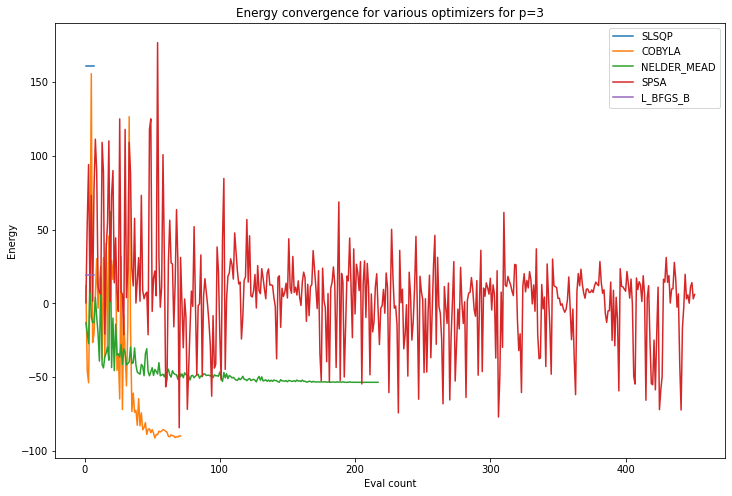

In [33]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title(f'Energy convergence for various optimizers for p={p}')
pylab.legend(loc='upper right');

In [34]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=op)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -180.74350


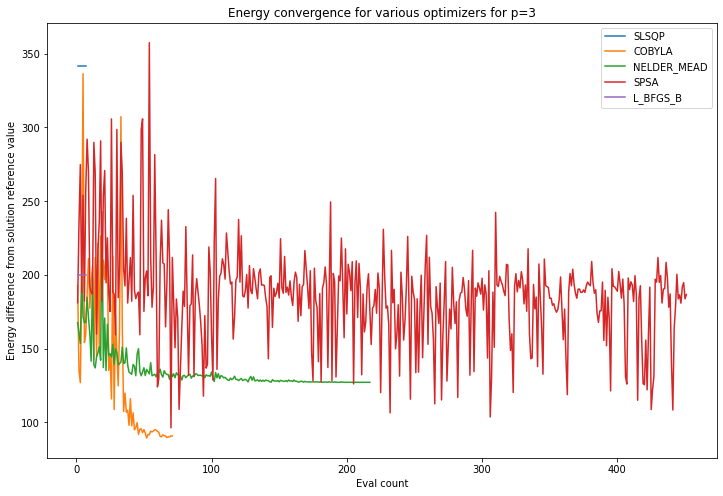

In [35]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
        pylab.plot(converge_cnts[i], abs(ref_value - converge_vals[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title(f'Energy convergence for various optimizers for p={p}')
pylab.legend(loc='upper right');

## Try with VQE 

In [47]:
ry = TwoLocal(op.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(op, ry, spsa, quantum_instance=quantum_instance)
result_vqe = vqe.run(quantum_instance)
print('energy:', result_vqe.eigenvalue.real)
print('time:', result_vqe.optimizer_time)
x = sample_most_likely(result_vqe.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)

energy: -35.54709327932248
time: 928.6647448539734
feasible: False
solution: [[0, 1], 2, 0]
